##  **Transfert learning(Faster R-CNN) : Prédiction de zones délimitantes les réçus ainsi que leur total**


--` *Objectif*` : Développer un système d'extraction d'informations pertinantes d'une image ( reçu et sa zone de total dans notre cas)


***Context*** : test de recrutement proposé par l'entreprise Youngapp : extraction de total sur des reçus non annotés(200 images) disponibles [ici](hhttps://expressexpense.com/blog/free-receipt-images-ocr-machine-learning-dataset/).
La tâche s'annonçant difficile sans annotations, je suis tombé dans mes recherches sur un dataset open source de reçus semblables déjà annotés (zone délimitante , menu, total, ect..).  Bingoooooooo
j'ai donc décidé d'aller plus loin en prédisant aussi la zone délimitant un reçu dans une image

Lien du dataset :  https://github.com/clovaai/cord);
Documentation du dataset: https://openreview.net/pdf

- les points abordées dans ce notebook sont:
-- Extraction des coordonnées délimitant les reçus et leur total des fichiers d'annotation
-- Sélection des reçus disposant de coordonnées de points les délimitant
-- Redimensionnement des images (moyenne des longueurs et largeurs des 4 premieres resolutions apparaissant le plus dans le dataset)
-- Modification des classes pytorch pour l'entrainement sur le dataset( certains fichiers et lignes de codes proviennent du répertoire [github](https://pytorch.org/tutorials/intermediate/torchvision_tutorial.html) officiel de pythorch : segmentation et prediction COCO) 
--  Utilisation d'un modèele Faster R-CNN avec un réseau ResNET-50 fPN pour l'entrainnement
-- Visualisation des résultats sur les données de test 

















#### **Import des bibliothèques utiles**

In [3]:
%matplotlib inline
import torch
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

import torchvision
from torchvision import transforms
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

from PIL import Image as Im
import numpy as np
import json
import copy

import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib.collections import PatchCollection
from matplotlib.patches import Patch

import os
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


from engine import train_one_epoch, evaluate

#### **Déplacement dans le repertoire de travail**


In [4]:
#
import os
os.chdir("/content/drive/MyDrive/Receipt_project")

In [5]:
pip freeze > requirementss.txt

In [ ]:
!ls

Annoted_data   dataset.ipynb		    main.ipynb	      utils.py
coco_eval.py   engine.py		    __pycache__
coco_utils.py  fasterrcnn_resnet50_fpn.pth  requirements.txt


In [13]:
from engine import train_one_epoch, evaluate

####Fonction pour extraire les coordonnées délimitant les reçus et leur total
--- Vous pouvez accéder à l'ensemble des données utilisés pour ce travail [ici](hhttps://drive.google.com/drive/folders/1P4g1rpCKoQhyV81kfDxHBPMbI7hpzP78)

In [14]:
def get_total_coord(json_path, json_file,img_path):
    """ traitement des reçus pour recupérer les coordonnées des boites englobantes(reçu et total)"""
    try:
        #dictionnaire des coordonnées des images et des zones de total
        coord = {}
        #chemin image
        img_file=json_file.replace('json','png')
        coord['img_path'] = '{}{}'.format(img_path,img_file)
        coord['img_name']=img_file

        #Taille image 
        img = Image.open(coord['img_path'])
        coord['img_size']=img.size
        coord['img_size_str']=str(img.size)
        coord['annot_path']='{}{}'.format(json_path,json_file)
        #print(coord)
        # Extraction des coordonnées de la zone de total
        with open(coord['annot_path'], 'r') as file:

            data = json.load(file)

        # On recupère le bloc valid_line qui contient les informations 
            receipt_data = data['valid_line']

            # 0n recupère le prix total s'il existe
            total_box = [value for value in receipt_data if value['category'] == 'total.total_price']

            # Sinon on recupère le prix total
            if not total_box :
                total_box  = [value for value in receipt_data if value['category'] == 'total.cashprice']

            # Sinon on recupère le creditcardprice
            if not total_box :
                total_box  = [value for value in receipt_data if value['category'] == 'total.creditcardprice']

            # Sinon on recupère le sous total
            if not total_box :
                total_box  = [value for value in receipt_data if value['category'] == 'sub_total.subtotal_price']

            # Sinon on recupère le change price
            if not total_box :
                total_box  = [value for value in receipt_data if value['category'] == 'total.changeprice']

            for bloc in total_box:
                data_bloc = bloc['words']

                # On recupère ici les coordonnées de la zone de prix et celle de total
                total_zone = [value['quad'] for value in data_bloc if value['is_key'] == 0]
                total_label = [value['quad'] for value in data_bloc if value['is_key'] == 1]

                if total_zone:
                    if total_label :
                        # if both are present return the full bounding box dans l'ordre (xmin,xmax,ymin,ymax)
                        coord['coord_total'] = [min(total_zone[0]['x1'], total_label[0]['x1']), 
                                                max(total_zone[0]['x2'], total_label[0]['x2']), 
                                                min(total_zone[0]['y1'], total_label[0]['y1']),  
                                                 max(total_zone[0]['y4'], total_label[0]['y4'])]
                    else:
                        # Sinon on recupère la zone de prix uniquement  dans l'ordre (xmin,xmax,ymin,ymax)
                        coord['coord_total'] = [total_zone[0]['x1'], total_zone[0]['x2'],
                                                 total_zone[0]['y1'], total_zone[0]['y4']]  
            #on recupère le bloc contenant les coordonnées délimitant les reçus
            roi = data['roi']
            #print(roi)
            if roi:
                #extraction des coordonnées
                coord['roi']=[roi['x1'], roi['x2'],
                roi['y1'], roi['y4']]  
            else:
                coord['roi']='none'
                        
    except Exception as e:
        print('error',e)
        coord=None
    return coord

####**Exploration et visualisation des données**

In [15]:
import os
import pandas as pd
from PIL import Image
import json
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

def format_dataset(data_type):
    """construction des datasets sous forme de dataframe"""

    json_path = 'Annoted_data/{}/json/'.format(data_type)
    img_train_path ='Annoted_data/{}/image/'.format(data_type)
    json_list=os.listdir(json_path)

    #creation de dataframe contenant les infos de chaque image 
    train_coord_list=[]
    for json_file in json_list :
        #on recupère les coodonnées des points délimitant les reçus et leur total
        coord = get_total_coord(json_path, json_file,img_path=img_train_path )
        #liste des  coordonnées 
        train_coord_list.append(coord)
    #transformation de la liste en dataframe
    dataframe=pd.DataFrame(train_coord_list)  
    
    return dataframe



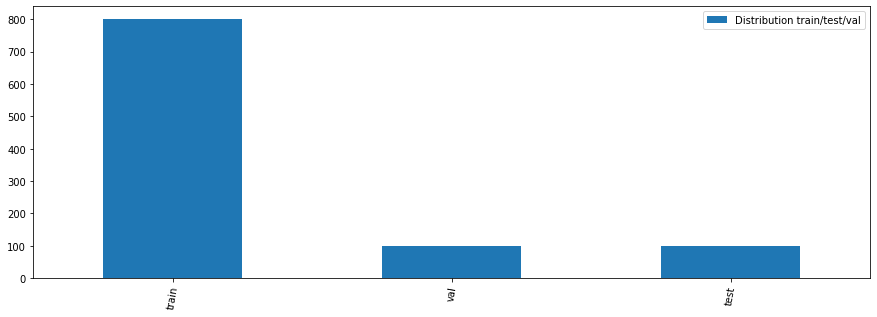

In [16]:
#on recupère toutes les images de nos dossiers
df_train=format_dataset('train')
df_train['set']='train'

df_test=format_dataset('test')
df_test['set']='test'

df_val=format_dataset('dev')
df_val['set']='val'

ax=pd.concat([df_train,df_test,df_val])['set'].value_counts().plot(kind='bar',rot='80', figsize=(15,5))
ax.legend(['Distribution train/test/val'])

**Commentaire:**
- Initialement on dispose de 800 images dans notre dataset de train contre 100 dans en validation et en test.

- Voyons combien possèdent des ooordonnées des 4 points délimitant les reçus

*-- Selection des images ayant les coordonnées des 4 points englobant les reçus*

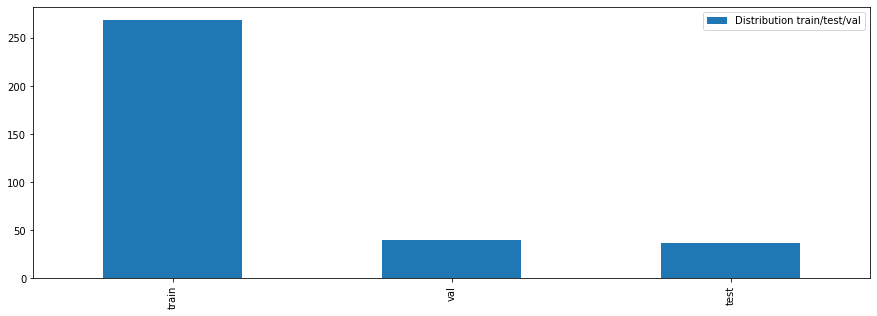

In [17]:
#on élimine les valeurs de coordonnées à none pour garder que les images ayant les coordonnées des 4 points délimitant les reçus
df_train=df_train[df_train['roi']!='none']


df_test=df_test[df_test['roi']!='none']


df_val=df_val[df_val['roi']!='none']

ax=pd.concat([df_train,df_test,df_val])['set'].value_counts().plot(kind='bar',rot='90', figsize=(15,5))
ax.legend(['Distribution train/test/val'])

**Commentaire** :
- On se retrouve avec 269 images de train contre une cinquantaine en validation et en test ce qui montre que plus de la moitié du dataset ne dispose pas des coordonnées englobant les reçus

- Regardons maintenant la distribution de resolution des images dans nouveau dataset de train

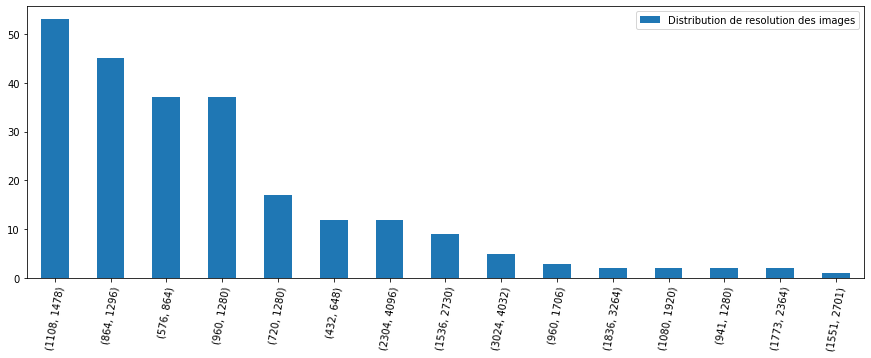

In [ ]:

ax=df_train.img_size_str.value_counts().head(15).plot(kind='bar',rot='80', figsize=(15,5))
ax.legend(['Distribution de resolution des images'])

**Commentaires:**
- On remarque ici que la resolution des images varie fortement.
Ainsi j'ai décidé de redimensionné toutes les images à la taille 817*1230 (moyenne des longueurs et largeurs des 4 premieres resolutions apparaissant le plus dans le dataset) afin d'éviter les distortions le plus possible et permettre la prise en charge de plusieurs images par lots par le GPU.
- Les coordonnées délimitant les reçus et leur total sont aussi redimensionnés en fonction de la. nouvelle resolution de l'image

**visualisation de certains reçus avec leur boites englobante et celle de leur total**

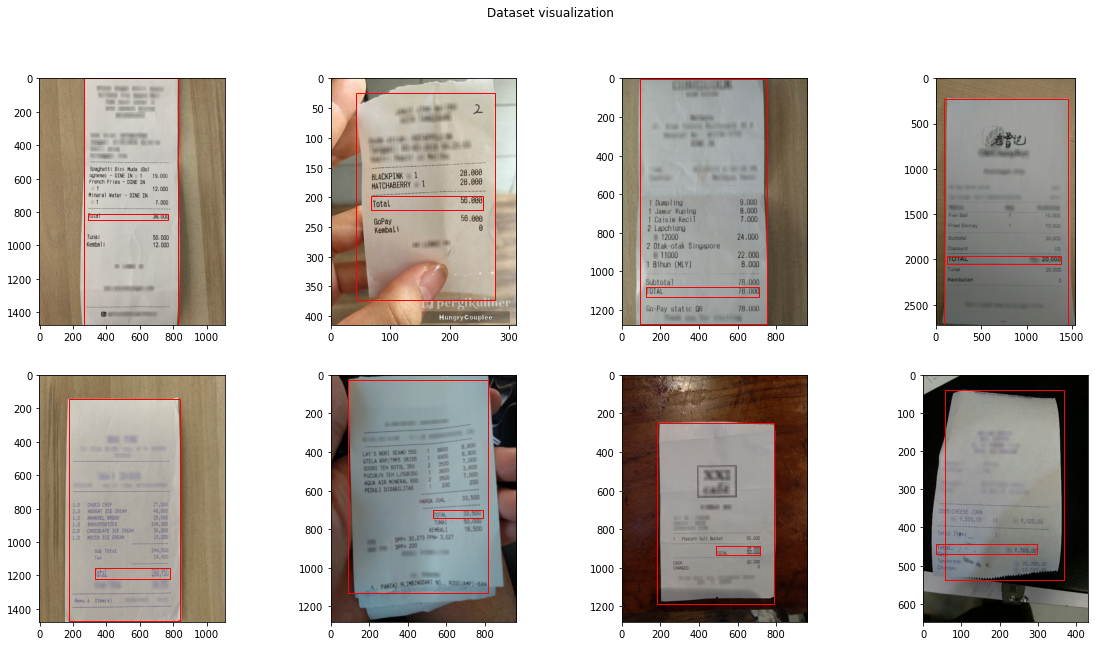

In [ ]:
def visualize_img(rows,columns,dataset):
    """  visualisation des reçuq"""
    fig, axs = plt.subplots(rows, columns, figsize=(20, 10))

    for idx in range (rows*columns):
        row=dataset.sample()
        img=Image.open(row.img_path.values[0])
        coord_ttc=row.coord_total.values[0]
        xmin_ttc=coord_ttc[0]
        xmax_ttc=coord_ttc[1]
        ymin_ttc=coord_ttc[2]
        ymax_ttc=coord_ttc[3]
        
        coord_receipt=row.roi.values[0]
        xmin_r=coord_receipt[0]
        xmax_r=coord_receipt[1]
        ymin_r=coord_receipt[2]
        ymax_r=coord_receipt[3]
       
       
        axs[idx // columns, idx % columns].imshow(img)

        rect_ttc = Rectangle(xy=(xmin_ttc, ymin_ttc), width=xmax_ttc - xmin_ttc,
                                height=ymax_ttc - ymin_ttc, 
                                linewidth=1, edgecolor='r', facecolor='none')
        rect_r = Rectangle(xy=(xmin_r, ymin_r), width=xmax_r - xmin_r,height=ymax_r - ymin_r,  linewidth=1, edgecolor='r', facecolor='none')
        
        axs[idx // columns, idx % columns].add_patch(rect_ttc)
        axs[idx // columns, idx % columns].add_patch(rect_r)
        
    plt.suptitle('Dataset visualization')
    plt.show()      

# visualize 6 elements
visualize_img(rows=2, columns=4, dataset=df_train)

**Commentaire:**
- On remarque que certaines coordonnées délimitant les reçus ne les encadrent pas parfaitement. Mais pour un début cela reste quand même des coordonnées qui permettront au modèle d'apprendre la boite englobante des reçus.

- Par contre les coordonnées délimitant le total des reçus ont l'air parfait

#### **Choix du modèle et modification des classes pythorch pour l'entrainement**

**Choix du modèle**

- J'ai opté pour un modèle **Faster R-CNN** avec comme réseau **ResNet-50 FPN** pour deux raisons : 
-- les zones délimitant les reçus et leur total sont de tailles différentes
différentes, la puisance du FPN permet de surmonter ce problème. 
-- Les connexions résiduelles limitent également le surapprentissage. \\

-Les modèles sont préformés sur la base de données de segmentation d'images et de détection d'objets [COCO](https://cocodataset.org/). 



### Modification de la classe Dataset de torch.utils.data: Cette classe Dataset fournit les informations de l'image telles que la classe à laquelle elle appartient et les positions des objets qu'elles contient

In [ ]:

class ReceiptDataset(Dataset):
    """ On hérite ici de la classe dataset pour sa modification """

    def __init__(self, dataframe, root_data_dir, subset, resize_img=None, resize_roi=None):
    
        self.dataframe=dataframe
        #on utilise le nom des fichiers comme id_unique
        self.image_ids=dataframe.img_name.unique()
        self.data_dir = os.path.join(root_data_dir, subset)
        self.subset = subset
        self.resize_img = resize_img
        self.resize_roi = resize_roi

        self.images_paths = os.listdir(os.path.join(self.data_dir, 'image'))
        self.targets_paths = os.listdir(os.path.join(self.data_dir, 'json'))

    def __len__(self) -> int:
        return self.image_ids.shape[0]

    def __getitem__(self, index):
          
        image_id = self.image_ids[index]
        #on recupère la ligne associée à chaque index(box reçu et total)
        row = self.dataframe[self.dataframe['img_name'] == image_id]
        total_box=row.coord_total.values[0]
        receipt_box=row.roi.values[0]
       

        image = Im.open(row.img_path.values[0])

        if self.resize_roi:
    
           #on transforme l'image dans la nouvelle taille définie
            total_box = self.resize_roi(total_box, original_shape=(image.size[1], image.size[0]))
            receipt_box = self.resize_roi(receipt_box, original_shape=(image.size[1], image.size[0]))
            
        if self.resize_img:
            image = self.resize_img(image)
        #concaténation des coodonnées du reçu et du total    
        boxes=[receipt_box,total_box]

        # création des formats appropriés de données pour tensorflow
        target = {}
        #target['boxes'] = torch.FloatTensor([price_bounding_box])
        target['boxes']= torch.as_tensor(boxes,dtype=torch.float32)
        
        #on a ici 2 classes
        target['labels'] =torch.as_tensor([1,2],dtype=torch.int64)
        target['image_id'] = torch.tensor([index])
        target['area'] = torch.tensor([(receipt_box[3] - receipt_box[1]) * (receipt_box[2] - receipt_box[0]), (total_box[3] - total_box[1]) * (total_box[2] - total_box[0])])
        target['iscrowd'] = torch.zeros((2,), dtype=torch.int64)

        return image, target


class RoiRescale(object):
    """Class de redimensionnement des images """
    
    def __init__(self, new_shape):
        assert isinstance(new_shape, tuple)
        self.new_shape = new_shape

    def __call__(self, sample, original_shape):
        w_ratio = new_shape[0] / original_shape[0]
        h_ratio = new_shape[1] / original_shape[1]
      
        #     xmin,                ymin,              xmax,              ymax
        return [sample[0]*h_ratio, sample[2]*w_ratio, sample[1]*h_ratio, sample[3]*w_ratio]

#### **Transformation des images dans la nouvelle résolution et visualisation**

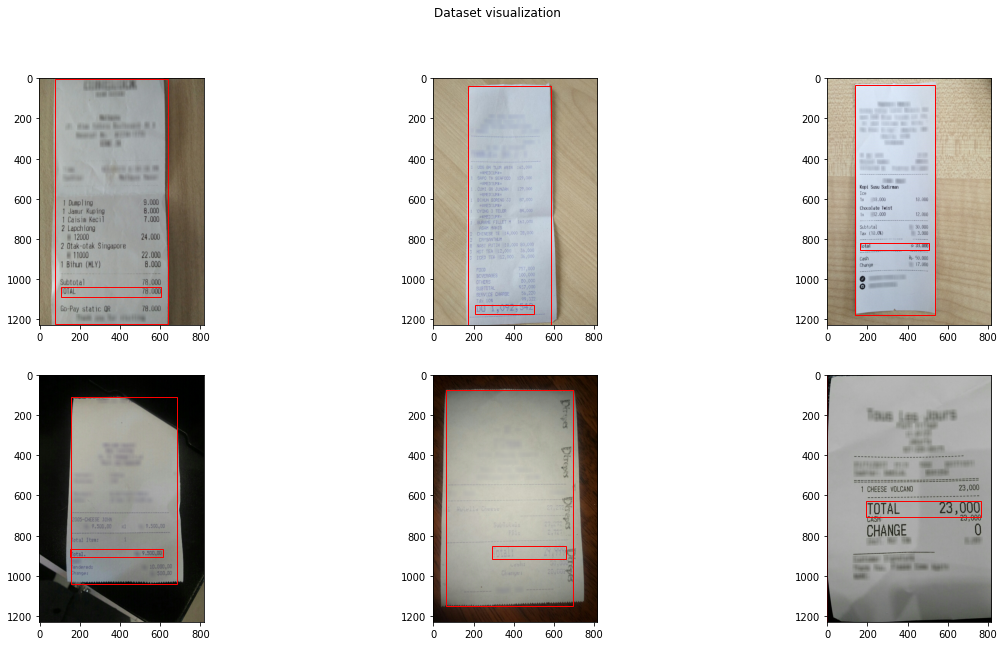

In [ ]:
new_shape = (1230, 817) # Nouvelle résolution de l'image

# Transformation de l'image dans la nouvelle résolution définie avec des pixels dans la plage [0-1]
resize_img = transforms.Compose([transforms.Resize(size=new_shape),
                                    transforms.ToTensor()])

# Transformation des coordonnées délimitant les reçus et leur total par rapport à la nouvelle résolution
resize_roi = RoiRescale(new_shape=new_shape)

# Création d'un dataset et dataloader temporaire
data =  ReceiptDataset(df_train,root_data_dir='Annoted_data', subset='train', resize_img=resize_img, resize_roi=resize_roi )
data_loader = torch.utils.data.DataLoader(data, batch_size=1, num_workers=0)

def visualize_dataset(dataset, n_rows, n_columns):
    """ Visualisatiion des nouvelles images redimentionnées  """

    indexes = np.random.randint(0, len(dataset), n_rows * n_columns)
    
    fig, axs = plt.subplots(n_rows, n_columns, figsize=(20, 10))

    for idx, sample_idx in enumerate(indexes):
        img, box = dataset[sample_idx]
        receipt_box = box["boxes"][0]
        total_box = box["boxes"][1]
        
        img = transforms.ToPILImage()(img)
        axs[idx // n_columns, idx % n_columns].imshow(img)

        receipt_box  = Rectangle(xy=(receipt_box [0], receipt_box [1]), width=receipt_box [2] - receipt_box [0],
                                height=receipt_box[3] - receipt_box[1], 
                                linewidth=1, edgecolor='r', facecolor='none')
        
        total_box   = Rectangle(xy=(total_box  [0], total_box  [1]), width=total_box  [2] - total_box  [0],
                                height=total_box [3] - total_box [1], 
                                linewidth=1, edgecolor='r', facecolor='none')
        
        axs[idx // n_columns, idx % n_columns].add_patch(receipt_box )
        axs[idx // n_columns, idx % n_columns].add_patch(total_box )
    plt.suptitle('Dataset visualization')
    plt.show()      

# visualisation de 5 reçus
visualize_dataset(dataset=data, n_rows=2, n_columns=3)

# Suppression du dataset temporaire 
del data
del data_loader

#### Téléchargement et définition du modèle Faster R-CNN ave son réseau ResNet-50 FPN (extrait modifié de la documentation pytorch)

In [ ]:
# Chargement de l'architechture model ResNet-50 FPN préformé sur le dataset  COCO
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

num_classes = 3  # background , zone délimitant les reçus et leur total


#Obtention du nombre d'entrées pour le classifieur Resnet
in_features = model.roi_heads.box_predictor.cls_score.in_features

# replace the pre-trained head with a new one and create the Fast R-CNN model
# modification de l'en-tête du modèle préformé avec de nouveaux pramètres(in_features,num_classes)
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


#### **Ajustement du modèle **
Paramètres:
* SGD avec taux d'apprentissage de 0,005, un momentum de 0,9 et une pénalité L2 avec un facteur de 0,0005 pour éviter le sur-ajustement.(Paramètres par défaut de la documentation officielle de pytorch)
* Taille de lot de longueur 8 (maximum possible en utilisant le GPU Tesla K80 de Google Colab avec 11 Go de mémoire) ce qui fait environ 34 images vues à chaque époch étant donné qu'on a 269 images en tout

* Epoch = 30


* Par défaut la fonction one_epoch renvoie un objet de type metric et ne retourne donc pas de perte de validation. Pour l'obtenir un ajustement du code est nécéssaire. Quant a la fonction evaluate elle retourne un objet de type Cocoevaluator resumant la précision moyenne et recall moyen des données de validation








# Entrainement 

In [ ]:

# fonction de callback pour changer le format de nos images en batch(tuple) au format liste et nos targets au format liste de dictionnaire
# images = [tensor([C,H,W]), tensor([C,H,W]), tensor([C,H,W])]
# list of dictionary targets = [{'boxes': tensor([2,4]), 'labels': tensor([1,2])}, 'boxes': tensor([2,4]), 'labels': tensor([1,2])},'boxes': tensor([2,4]), 'labels': tensor([1,2])}]
def collate_fn(batch):
    return tuple(zip(*batch))

# Entrainement sur le gpu si le cpu n'est ps disponible
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

#Chargement de nos datasets
dataset =  ReceiptDataset(df_train,root_data_dir='Annoted_data', subset='train', resize_img=resize_img, resize_roi=resize_roi)
dataset_val=  ReceiptDataset(df_val,root_data_dir='Annoted_data', subset='dev', resize_img=resize_img, resize_roi=resize_roi)
dataset_test =  ReceiptDataset(df_test,root_data_dir='Annoted_data', subset='test', resize_img=resize_img, resize_roi=resize_roi )

# definition des data_loader de train et de validation
train_data_loader = torch.utils.data.DataLoader(
        dataset, batch_size=8, shuffle=True, num_workers=4, collate_fn=collate_fn)

data_loader_test = torch.utils.data.DataLoader(
        dataset_test, batch_size=8, shuffle=False, num_workers=4, collate_fn=collate_fn)


data_loader_val = torch.utils.data.DataLoader(
        dataset_val, batch_size=8, shuffle=False, num_workers=4, collate_fn=collate_fn)

# Utilisation du GPU pour l'entrainement du modèle
model.to(device)

# Optimiseur SGD
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                            momentum=0.9, weight_decay=0.0005)

# definition de l'optimiseur SGD et du taux d'apprentissage
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

#definition de la perte d'entropie croisée
f_loss = torch.nn.CrossEntropyLoss()

# train for 30 epochs
num_epochs = 30

train_loss_list=[]

for epoch in range(num_epochs):
    dict_train_loss={}

    # Entrainnement d'une epoch , avec affichage chaque 100 itérations(fonction mmodifiée pour récupérer la perte d'entrainement)
    train_metrics, loss =train_one_epoch(model, optimizer, train_data_loader, device, epoch, print_freq=34)
    #On recupére la valeur d'epoch et de perte pour le tracé à la fin de l'entrainement
    dict_train_loss['epoch']=epoch
    dict_train_loss['loss']=loss.item()
    train_loss_list.append(dict_train_loss)

    # Mise à jour du taux d'apprentissage
    lr_scheduler.step()

    # evalution sur le dataset de validation
    evaluate(model, data_loader_val ,device=device)

#torch.save(model.state_dict(), 'fasterrcnn_resnet50_fpn.pth')
torch.save(model,'model')

Epoch: [0]  [ 0/34]  eta: 0:02:53  lr: 0.000156  loss: 0.2034 (0.2034)  loss_classifier: 0.0408 (0.0408)  loss_box_reg: 0.0793 (0.0793)  loss_objectness: 0.0119 (0.0119)  loss_rpn_box_reg: 0.0715 (0.0715)  time: 5.1165  data: 2.6220  max mem: 10164
Epoch: [0]  [33/34]  eta: 0:00:02  lr: 0.005000  loss: 0.1931 (0.1930)  loss_classifier: 0.0407 (0.0384)  loss_box_reg: 0.0691 (0.0669)  loss_objectness: 0.0156 (0.0184)  loss_rpn_box_reg: 0.0625 (0.0694)  time: 2.1627  data: 0.0293  max mem: 10323
Epoch: [0] Total time: 0:01:16 (2.2582 s / it)
creating index...
index created!
Test:  [0/5]  eta: 0:00:16  model_time: 1.0013 (1.0013)  evaluator_time: 0.0299 (0.0299)  time: 3.3939  data: 2.2758  max mem: 10323
Test:  [4/5]  eta: 0:00:01  model_time: 0.9425 (0.9521)  evaluator_time: 0.0128 (0.0161)  time: 1.4875  data: 0.4798  max mem: 10323
Test: Total time: 0:00:07 (1.5090 s / it)
Averaged stats: model_time: 0.9425 (0.9521)  evaluator_time: 0.0128 (0.0161)
Accumulating evaluation results...
DO

**Commentaire** : On obtient une précision moyennede 82.4%  pour un iou de 0.5 et 69.1 pour un IoU de 0.75 de  qui est un bon résultat pour unentrainement sur si peu de données

### Perte d'entrainement 

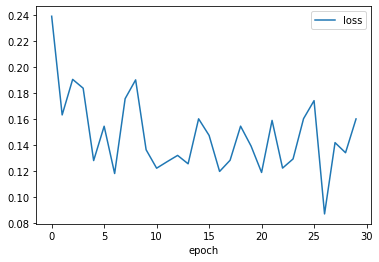

In [ ]:
ax=pd.DataFrame(train_loss_list).plot(x='epoch',y='loss',kind='line')


On remarque que 5 epoch sont suffisantes pour la convergence du modèle. à partir de cette 5eme époch le modèle ne s'améliore plus et la perte varie entre 0.10 et 0.16

In [ ]:
#zone pour charger le modèle pour une utilsation ultérieure 
#model = torch.load('model)
#model.eval()

#### Visualisation des prédictions du model


##### Visualisation des prédictions du modèle sur des données de test

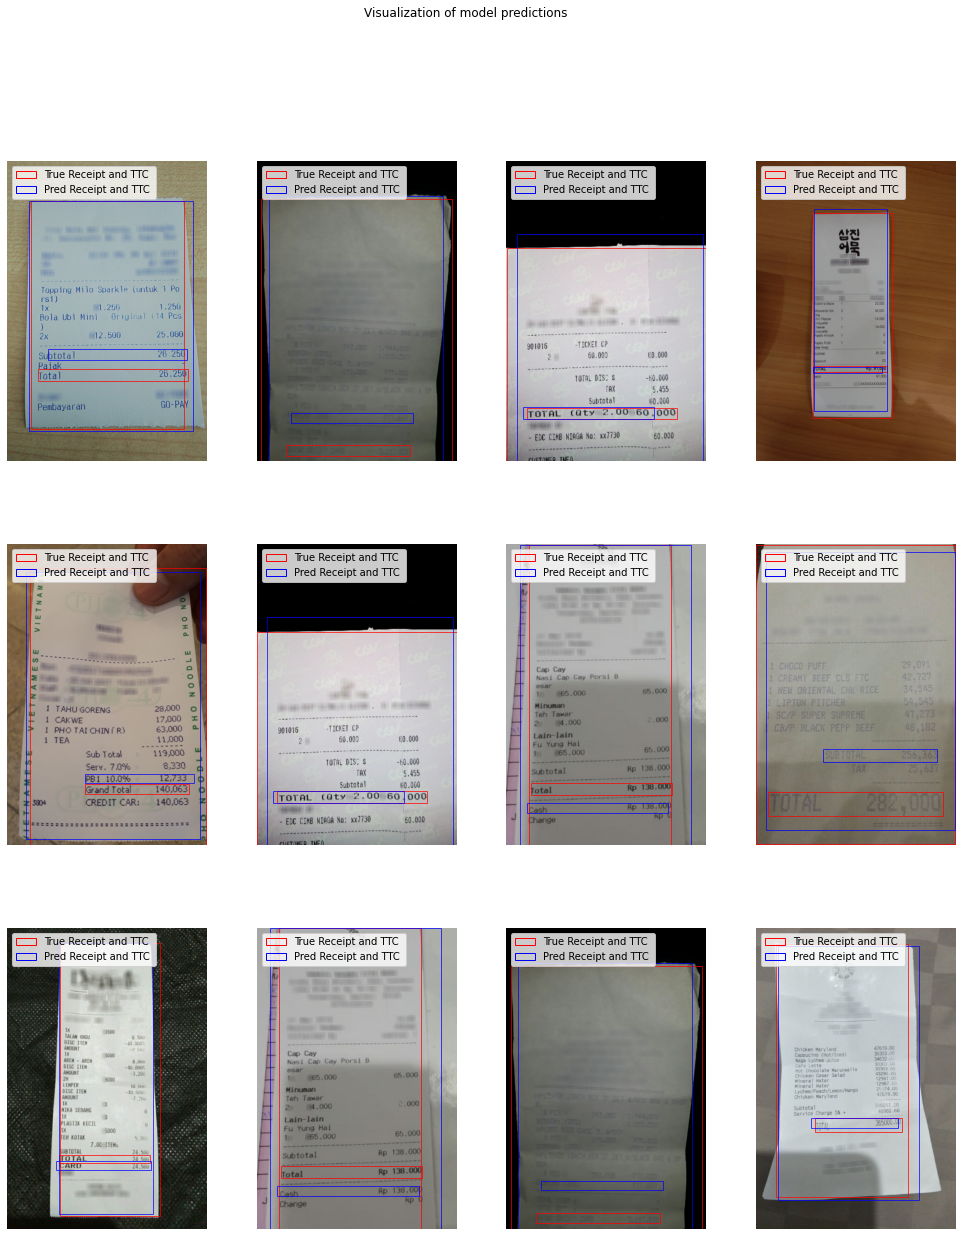

In [ ]:
def visualize_prediction(model, dataset, n_rows, n_columns, brut_data= None):
    """ Visualisation des prédictions """
    model.eval() # on définit le model en mode évaluation

    np.random.seed(40)

    # rondom d'indexes à tracer
    indexes = np.random.randint(0, len(dataset), n_rows * n_columns)
    
    fig, axs = plt.subplots(n_rows, n_columns, figsize=(17, 20))

    for idx, sample_idx in enumerate(indexes):
        img, true_roi = dataset[sample_idx] # selection random d'une image
        true_receipt = true_roi["boxes"][0]
        true_total = true_roi["boxes"][1]

        # 
        #Obtention des resultats de prédition pour une image et copie du résultat du GPU vers le CPU
        
         
        prediction = model([img.to(device)])[0]#.detach().cpu().numpy()
        #On recupère toutes les prédictions sous forme de tuple(box,classe,score) par ordre de précision
        data_zip=list(zip(*[v for k,v in prediction.items()]))
        #0n recupère les tuples appartenant à la classe 1(detection de contour de reçu)
        all_receipt_pred = [value for value in data_zip if value[1]==1]
        #0n recupère les tuples appartenant à la classe 2(zone délimitant le total)
        all_total_pred = [value for value in data_zip if value[1]==2]

        #print('pred_roi',pred_roi[0:2])

        # transform the PyTorch Tensor to PIL format 
        #transformation du tensor pythorh au format PIL pour matplotlib
        img = transforms.ToPILImage()(img)

        axs[idx // n_columns, idx % n_columns].imshow(img)

        # create  de rectangle en rouge pour les vraies coordonnées délimitant le réçu et son total
     
        true_receipt = Rectangle(xy=(true_receipt[0], true_receipt[1]), width=true_receipt[2] - true_receipt[0],
                                  height=true_receipt[3] - true_receipt[1], 
                                  linewidth=1, edgecolor='red', facecolor='none', alpha=0.7)
          
        true_total = Rectangle(xy=(true_total[0], true_total[1]), width=true_total[2] - true_total[0],
                                  height=true_total[3] - true_total[1], 
                                  linewidth=1, edgecolor='red', facecolor='none', alpha=0.7)

        if not brut_data:

            axs[idx // n_columns, idx % n_columns].add_patch(true_receipt)
            axs[idx // n_columns, idx % n_columns].add_patch(true_total)


        #Si prédiction de zone de reçu alors on affiche le premiers élement avec le meilleur score
        if all_receipt_pred :
         
          all_receipt_pred = all_receipt_pred[0][0].detach().cpu().numpy()
          #print(all_receipt_pred)
         
          receipt_pred= Rectangle(xy=(all_receipt_pred[0], all_receipt_pred[1]), width=all_receipt_pred[2] - all_receipt_pred[0],
                                height=all_receipt_pred[3] - all_receipt_pred[1], 
                                linewidth=1, edgecolor='blue', facecolor='none', alpha=0.7)
          
          
        #Si prédiction de zone de total alors on affiche le premiers élement avec le meilleur score
        if all_total_pred :
          all_total_pred = all_total_pred[0][0].detach().cpu().numpy()
          total_pred = Rectangle(xy=(all_total_pred[0], all_total_pred[1]), width=all_total_pred[2] - all_total_pred[0],
                                        height=all_total_pred[3] - all_total_pred[1], 
                                        linewidth=1, edgecolor='blue', facecolor='none', alpha=0.7)
          
        axs[idx // n_columns, idx % n_columns].add_patch(receipt_pred)
        axs[idx // n_columns, idx % n_columns].add_patch(total_pred)


        legend_elements = [Patch(facecolor='none', edgecolor='red', 
                                label='True Receipt and TTC '),
                          Patch(facecolor='none', edgecolor='blue',
                                label='Pred Receipt and TTC'),]

        axs[idx // n_columns, idx % n_columns].legend(handles=legend_elements, loc='upper left')
        axs[idx // n_columns, idx % n_columns].axis('off')

    plt.subplots_adjust(wspace=0.25, hspace=0.2)
    plt.suptitle('Visualization of model predictions')
    plt.show()      

# visualize predictions
visualize_prediction(model=model, dataset=dataset_test, n_rows=3, n_columns=4)


**Commentaire:** 0n remarque que même si les prédictions des zones modèle ne cadrent pas parfaitement avec les vraies zones celles ci restent très proches.
on voit bien que le modèle a bien appris de la forme des réçus et de la zone de total

In [ ]:
type(prediction)

dict

##### Voyons maintenant comment le modèle se comporte sur des données de tailles différentes de la résolution définie pour l'entrainement (données de validation)

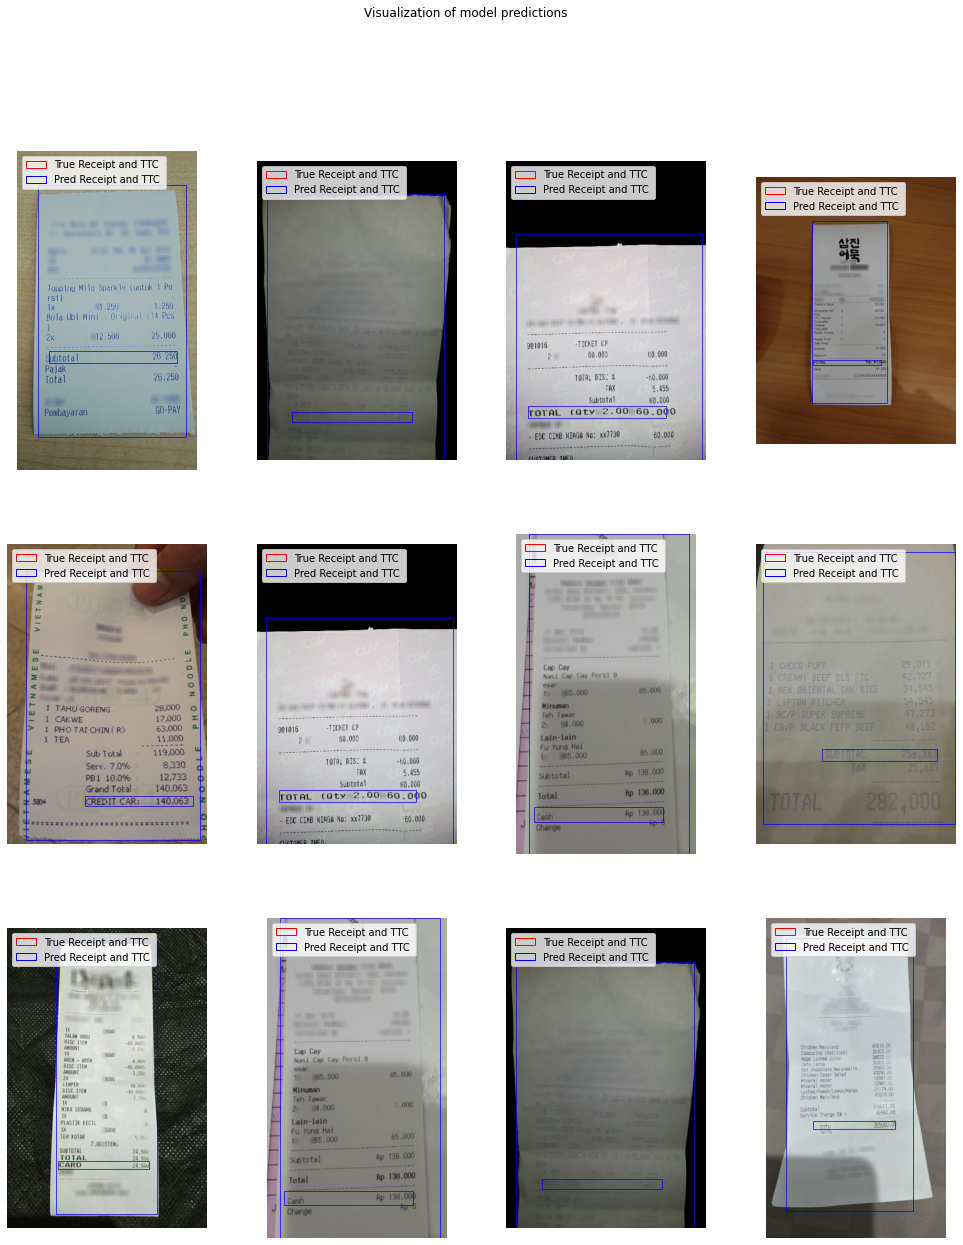

In [ ]:

Dataset_brut =  ReceiptDataset(df_test,root_data_dir='Annoted_data', subset='test', resize_img=transforms.ToTensor())
visualize_prediction(model=model, dataset=untransformed_dataset_test, n_rows=3, n_columns=4, brut_data=True)

### commentaire:
Toooooooooop : le modèle se comporte aussi très bien même sur les images non redimentionnées



## Appliquons maintenant notre modèle à notre dataset initial fourni pour le test n'ayant pas d'annotations

[ 82  91  12 119 115  27]


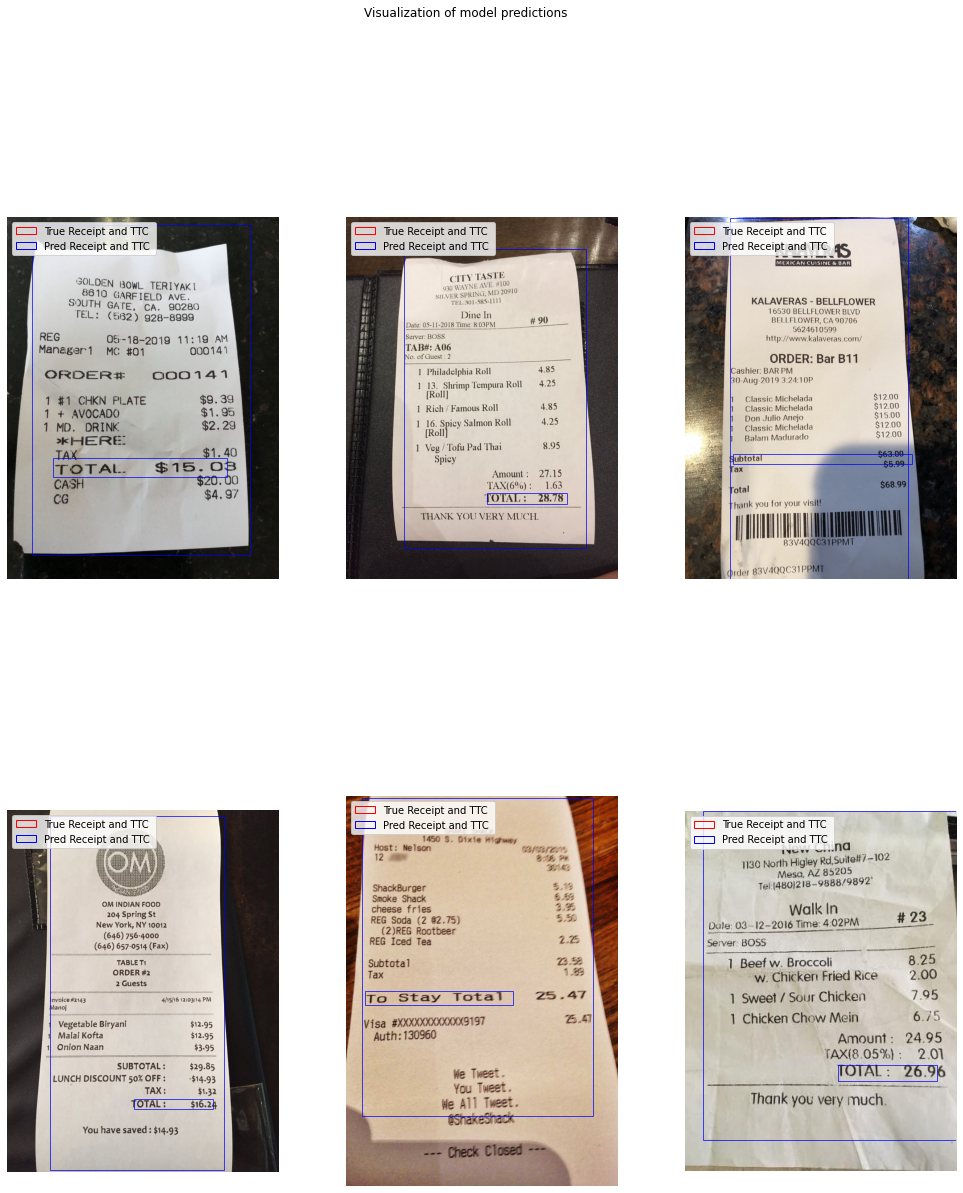

In [ ]:
path= 'Annoted_data/Express_dataset/'
express_list= os.listdir(path)
path_list=[]
for img_name in express_list:
  name=path+img_name
  path_list.append(name)

def visualise_express(path_list, n_rows, n_columns):

  #np.random.seed(40)

      # rondom d'indexes à tracer
  indexes = np.random.randint(0, len(path_list), n_rows * n_columns)
      
  fig, axs = plt.subplots(n_rows, n_columns, figsize=(17, 20))
  print(indexes)
  model1.eval()
  for idx,val in enumerate(indexes):
    

    img = Im.open(path_list[val]) 

    axs[idx // n_columns, idx % n_columns].imshow(img)
    #axs[idx // n_columns, idx % n_columns].imshow(img)
  #my_img = img.resize(new_shape)
    img = transforms.ToTensor()(img)   

    prediction = model([img.to(device)])[0]#.detach().cpu().numpy()
            #On recupère toutes les prédictions sous forme de tuple(box,classe,score) par ordre de précision
    data_zip=list(zip(*[v for k,v in prediction.items()]))
            #0n recupère les tuples appartenant à la classe 1(detection de contour de reçu)
    all_receipt_pred = [value for value in data_zip if value[1]==1]
            #0n recupère les tuples appartenant à la classe 2(zone délimitant le total)
    all_total_pred = [value for value in data_zip if value[1]==2]

 

    if all_receipt_pred :
            
      all_receipt_pred = all_receipt_pred[0][0].detach().cpu().numpy()
              #print(all_receipt_pred)
            
      receipt_pred= Rectangle(xy=(all_receipt_pred[0], all_receipt_pred[1]), width=all_receipt_pred[2] - all_receipt_pred[0],
                                    height=all_receipt_pred[3] - all_receipt_pred[1], 
                                    linewidth=1, edgecolor='blue', facecolor='none', alpha=0.7)
              
              
            #Si prédiction de zone de total alors on affiche le premiers élement avec le meilleur score
    if all_total_pred :

      all_total_pred = all_total_pred[0][0].detach().cpu().numpy()
      total_pred = Rectangle(xy=(all_total_pred[0], all_total_pred[1]), width=all_total_pred[2] - all_total_pred[0],
                                            height=all_total_pred[3] - all_total_pred[1], 
                                            linewidth=1, edgecolor='blue', facecolor='none', alpha=0.7)
              
    axs[idx // n_columns, idx % n_columns].add_patch(receipt_pred)
    axs[idx // n_columns, idx % n_columns].add_patch(total_pred)


    legend_elements = [Patch(facecolor='none', edgecolor='red', 
                                    label='True Receipt and TTC '),
                              Patch(facecolor='none', edgecolor='blue',
                                    label='Pred Receipt and TTC'),]

    axs[idx // n_columns, idx % n_columns].legend(handles=legend_elements, loc='upper left')
    axs[idx // n_columns, idx % n_columns].axis('off')

  plt.subplots_adjust(wspace=0.25, hspace=0.2)
  plt.suptitle('Visualization of model predictions')
  plt.show()  

visualise_express(path_list, n_rows=2, n_columns=3)

### **Commentaire** le modèle se comporte aussi bien sur les données express malgré la mauvaise qualité de certaines images

In [19]:
model = torch.load('model')
#model.eval()

In [1]:
import torch
print(torch.__version__)

1.7.0+cu101


##### Visualisation des prédictions sur un de mes reçus de brest pris en photo

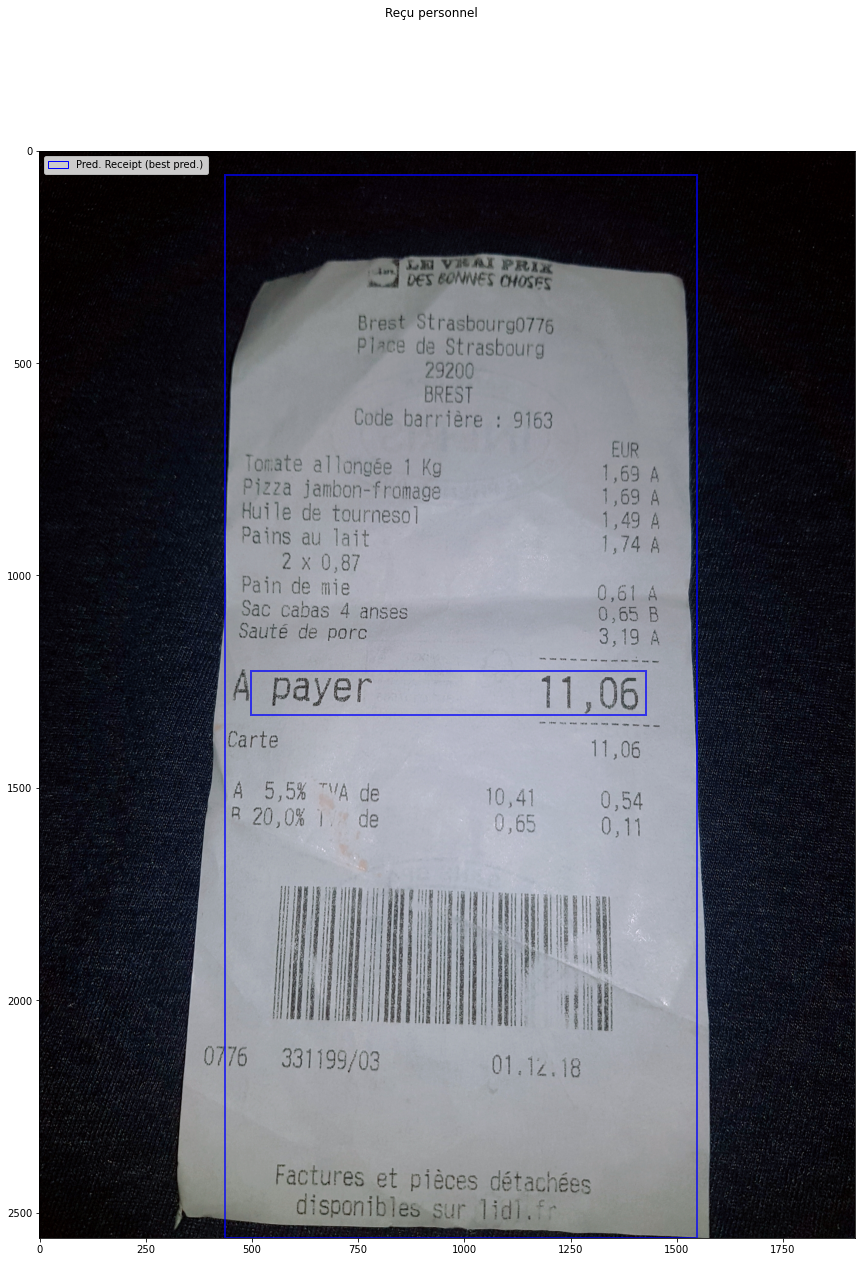

In [25]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
my_img_path = 'Annoted_data/personal/B612_20201202_022212_297.jpg' # image path to my personal receipt
my_img = Im.open(my_img_path) 

#my_img = img.resize(new_shape)
my_img_tensor = transforms.ToTensor()(my_img)

model.eval()
with torch.no_grad():
    ttc_preds = model([my_img_tensor.to(device)])[0]['boxes'].detach().cpu().numpy()
fig, ax = plt.subplots(1, figsize=(17, 20))

ax.imshow(my_img)
pred_receipt = ttc_preds[0]
pred_total= ttc_preds[1]
pred_receipt= Rectangle(xy=(pred_receipt[0], pred_receipt[1]), width=pred_receipt[2] - pred_receipt[0],
                                        height=pred_receipt[3] - pred_receipt[1], 
                                        linewidth=2, edgecolor='blue', facecolor='none', alpha=0.7)

pred_total = Rectangle(xy=(pred_total[0], pred_total[1]), width=pred_total[2] - pred_total[0],
                                        height=pred_total[3] - pred_total[1], 
                                        linewidth=2, edgecolor='blue', facecolor='none', alpha=0.7)
ax.add_patch(pred_receipt)
ax.add_patch(pred_total)

legend_elements = [Patch(facecolor='none', edgecolor='blue',
                  label='Pred. Receipt (best pred.)')]
ax.legend(handles=legend_elements, loc='upper left')
fig.suptitle('Reçu personnel')
plt.savefig('test.png')
plt.show()

* le modèle prédit plutot bien la zone de reçu independamment de la langue qui est ici le français 

##### **Conclusion**

* Nous avons ici mis en place un modèle deep learning capable de prédire la zone délimitante d'un reçu et sa zone de total. Le modèle fonctionne relativement bien sur les images de bonnes qualités avec des background différents de la couleur des reçus

* Ces prédictions peuvent permettre non seulement d'extraire les recus d'une image en rognant avec ses coordonnées, ce qui permettra de les traiter plus facilement et d'en extraire des information pertinantes

Des améliorations sont possibles en recoltant plus de données et en appliquant des transformations d'images telles que des rotations et zoom afin de pouvoir mieux traiter les images de mauvaises qualités

### Quelle est la suite??? :
-- Utilisation d'ocr pour extraire les informationq de total en zommant sur le reçu dans un premier temps grâce aux coordonnées de sa zone délimitante 